In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib as mpl

In [4]:
mnist = loadmat("mnist-original.mat")
mnist = {
    "data":mnist["data"].T,
    "targets":mnist["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}

In [5]:
X, y = mnist["data"], mnist["targets"]

In [7]:
#Train-test splitting

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([X[0]])

array([0.])

In [9]:
some_digit_score = svm_clf.decision_function([X[0]])
some_digit_score

array([[ 9.31776763,  0.69966542,  8.26937495,  3.82063539, -0.30671293,
         7.27141643,  3.80978873,  1.72165536,  6.0316466 ,  3.83885601]])

In [10]:
np.argmax(some_digit_score)

0

In [11]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[0]])

array([0.])

In [13]:
sgd_clf.decision_function([X[0]])

array([[ 16252.11480646, -24162.53103468, -11371.81035239,
         -9641.21284138, -18811.19488443, -15003.17319783,
        -15491.02110397, -22525.55027968,  -7410.99942089,
         -8584.58212046]])

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8772 , 0.8723 , 0.87055])

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8992 , 0.89135, 0.90145])

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5582,    0,   23,    8,    9,   54,   36,    6,  204,    1],
       [   0, 6407,   38,   26,    4,   46,    4,    8,  197,   12],
       [  26,   27, 5255,   91,   72,   27,   66,   37,  347,   10],
       [  22,   19,  120, 5240,    2,  212,   27,   40,  377,   72],
       [  10,   15,   47,    9, 5220,   12,   36,   24,  308,  161],
       [  27,   17,   31,  168,   55, 4484,   75,   15,  489,   60],
       [  30,   15,   43,    2,   43,   99, 5558,    3,  124,    1],
       [  20,   10,   52,   31,   50,   14,    3, 5700,  175,  210],
       [  17,   67,   49,   92,    3,  134,   24,   10, 5412,   43],
       [  26,   19,   31,   68,  113,   38,    1,  177,  351, 5125]],
      dtype=int64)

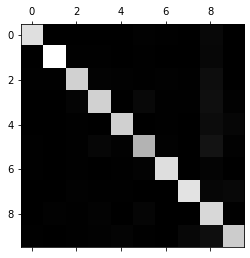

In [17]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [19]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

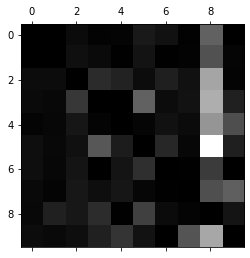

In [20]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [30]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

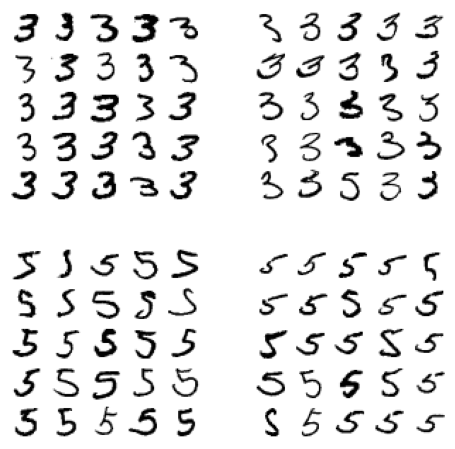

In [31]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [36]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_scaled, y_multilabel)

KNeighborsClassifier()

In [33]:
knn_clf.predict([X[0]])

array([[False, False]])

In [37]:
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.3012137484952992

In [38]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [44]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

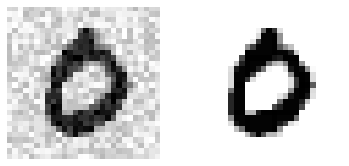

In [45]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

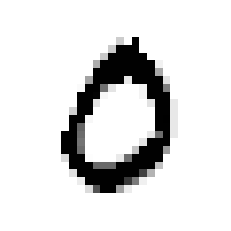

In [47]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)